In [1]:
import os
import csv
import lightkurve as lk
from lightkurve import search_targetpixelfile
#import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import leastsq
from tqdm import tqdm
import astropy.units as u
import pylab as plt
tpf = search_targetpixelfile('212136544', mission='K2').download()

/anaconda3/lib/python3.6/site-packages/lightkurve/search.py:181: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [2]:
tpf

KeplerTargetPixelFile Object (ID: 212136544)

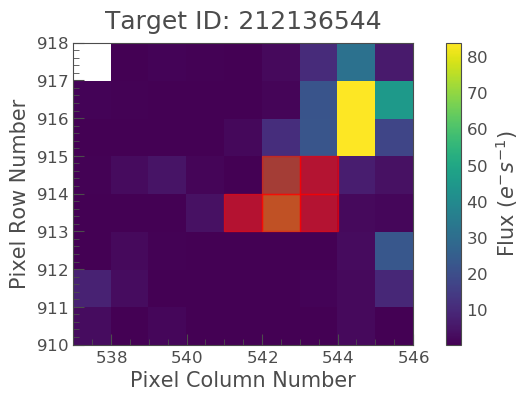

In [3]:
%matplotlib inline
tpf.plot(aperture_mask=tpf.pipeline_mask, mask_color='red')

[2306.61048395 2306.63091609 2306.65134804 ... 2381.3907183  2381.41115034
 2381.43158228]
[145.55992 139.17474 137.58304 ... 135.27925 131.67526 119.74176]


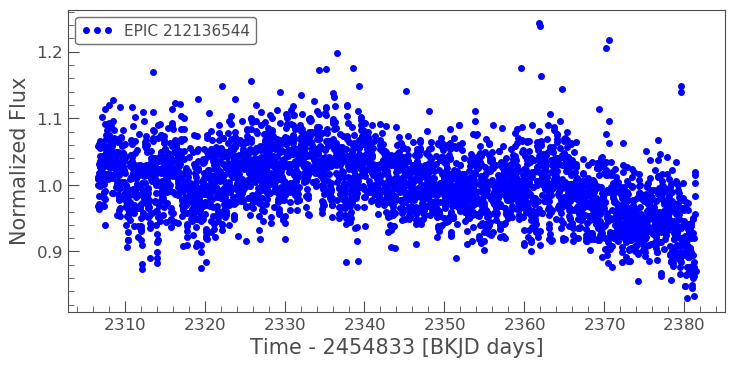

In [4]:
import matplotlib.pyplot as plt

user_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool))
# Clean the light curve
user_lc = user_lc.remove_nans().remove_outliers()
user_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')
#plt.ylim(0.9,1.1)
print(user_lc.time)
print(user_lc.flux)

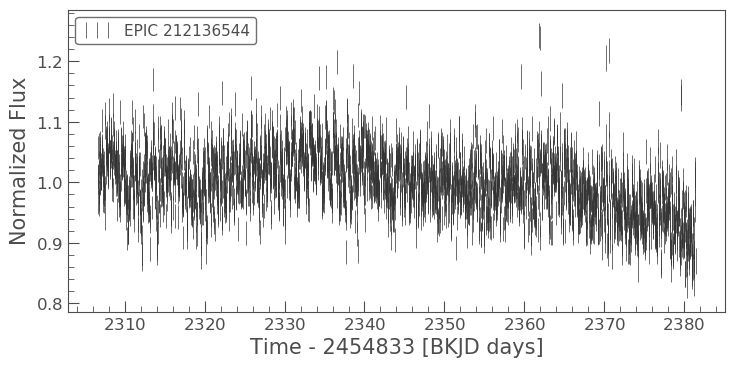

In [5]:
user_lc.errorbar();

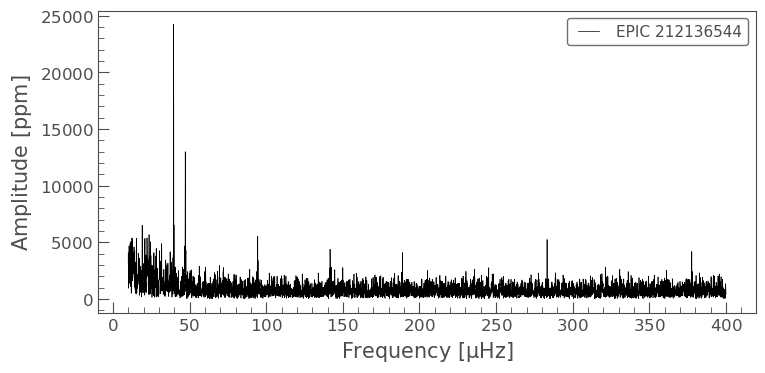

In [6]:
p = user_lc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = p.plot(c='k');

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.2921762 d>

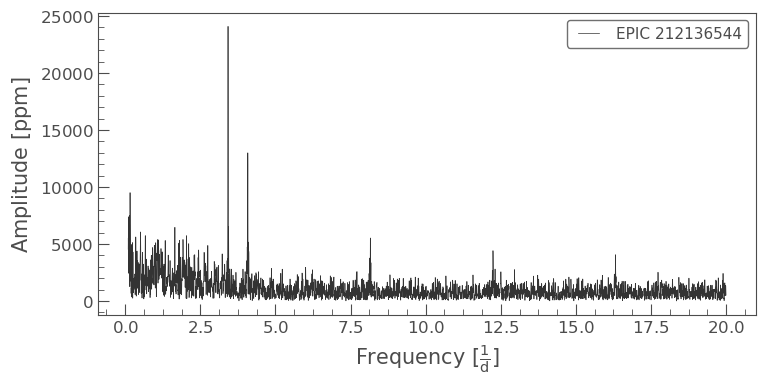

In [7]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc, minimum_period=0.05, maximum_period =10)
periodogram.plot()
periodogram.period_at_max_power

In [12]:
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
clc = lc.correct(windows=10).remove_outliers().fill_gaps()

/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)


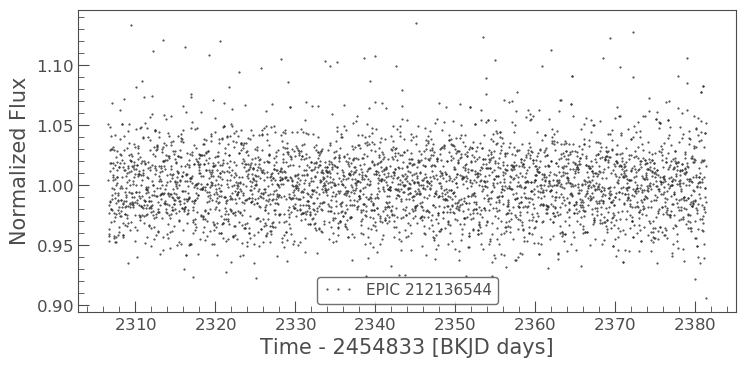

In [13]:
clc.plot(linestyle='none',marker='.')
stddev=np.std(clc.flux)

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.29232905 d>

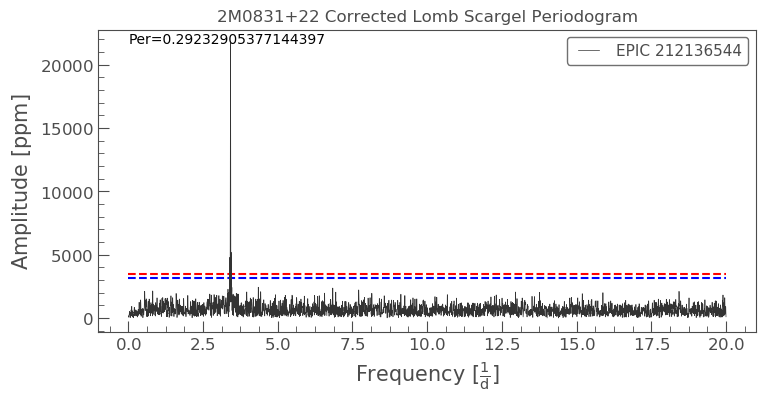

In [14]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
plt.hlines(percentile95,0,20,linestyle='--', color='blue')
plt.hlines(percentile99,0,20,linestyle='--', color='red')
plt.text(0,periodogram.max_power.value,"Per=%s"%(periodogram.period_at_max_power.value))
plt.title('2M0831+22 Corrected Lomb Scargel Periodogram')
periodogram.period_at_max_power

In [11]:
     from numpy import random
     maxpower=[]
     for i in range (1000):
          sim_lc=clc
     #make array and put it into sim_lc.flux
          sim_lc.flux=random.normal(1,stddev,len(sim_lc.time))
          periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(sim_lc, minimum_period=0.05, maximum_period =10)
          maxpower.append(periodogram.max_power.value)

     percentile95=np.percentile(maxpower,95)
     percentile99=np.percentile(maxpower,99)

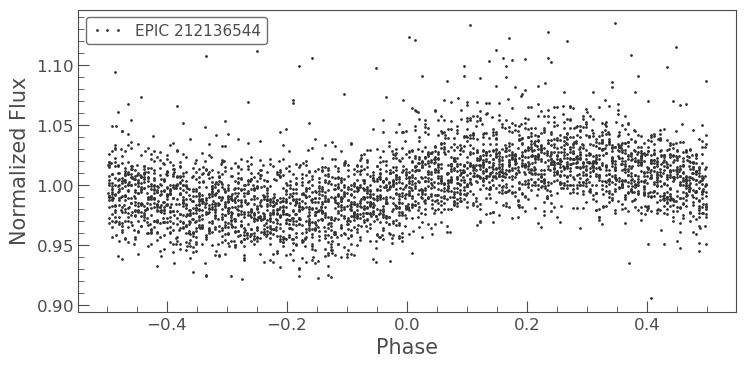

In [15]:
folded_lightcurve = clc.fold(periodogram.period_at_max_power.value)
folded_lightcurve.plot(marker='o',linestyle='none')

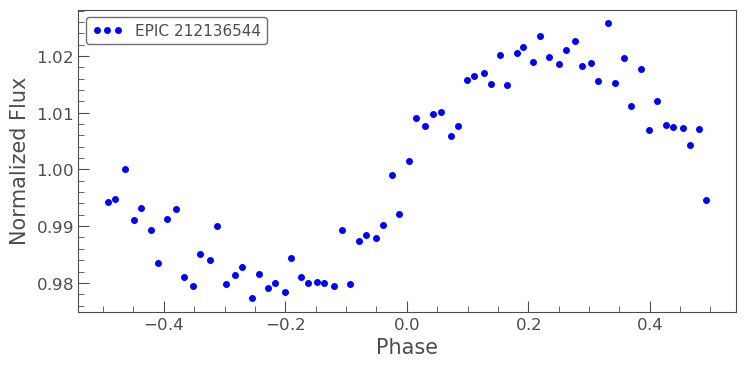

In [16]:
bin_folded_lc = folded_lightcurve.bin(50,method='median')
bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')

In [17]:
corrector=lk.SFFCorrector(lc)
new_lc = corrector.correct(lc.centroid_col,lc.centroid_row)

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


0.29232905377144397


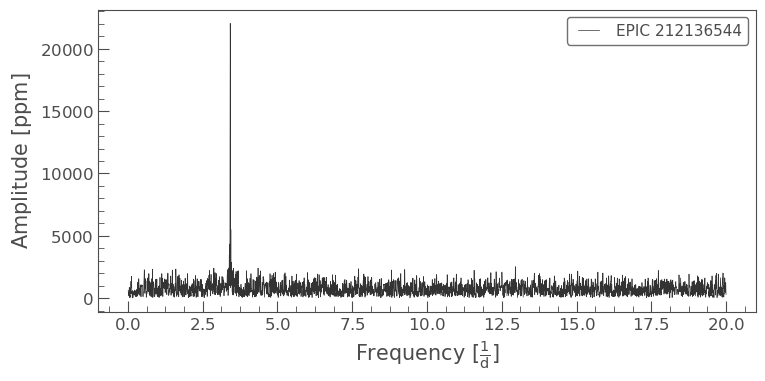

In [18]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(new_lc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
THEPERIOD=periodogram.period_at_max_power
print(THEPERIOD.value)

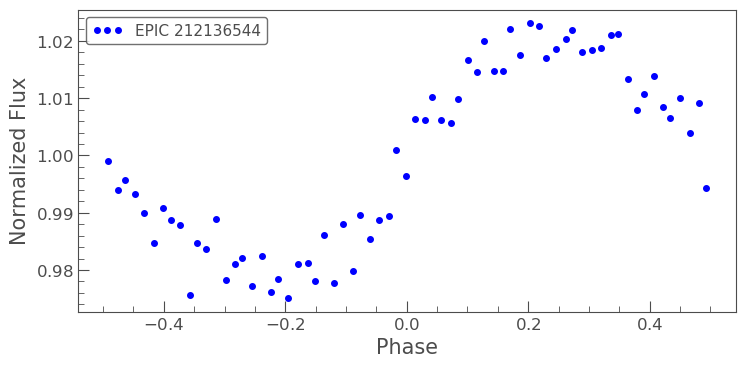

In [19]:
folded_lightcurve = new_lc.fold(periodogram.period_at_max_power.value)
bin_folded_lc = folded_lightcurve.bin(50,method='median')
bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue')

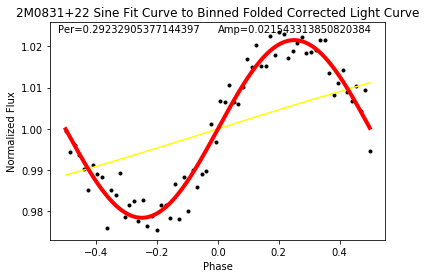

In [21]:
N = len(bin_folded_lc.flux) # number of data points
t = np.linspace(-0.5, 0.5, N)
guess_mean = np.mean(bin_folded_lc.flux)
guess_std = 3*np.std(bin_folded_lc.flux)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc.flux
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
fine_t = np.arange(-0.5,0.5,0.001)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
plt.plot(t, bin_folded_lc.flux, marker='.', linestyle='none', color='black')
plt.plot(t, data_first_guess, label='first guess', color='yellow')
plt.plot(fine_t, data_fit, label='after fitting', color='red', linewidth='4')
y_max=max(bin_folded_lc.flux)
plt.text(-0.525,y_max,"Per=%s"%(periodogram.period_at_max_power.value))
plt.text(0,y_max,"Amp=%s"%(est_amp))
plt.title('2M0831+22 Sine Fit Curve to Binned Folded Corrected Light Curve')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.savefig('Jupyter0831+22.png')

In [21]:
first10time=[]
second10time=[]
third10time=[]
fourth10time=[]
fifth10time=[]
sixth10time=[]
seventh10time=[]
eighth10time=[]
ninth10time=[]
first10flux=[]
second10flux=[]
third10flux=[]
fourth10flux=[]
fifth10flux=[]
sixth10flux=[]
seventh10flux=[]
eighth10flux=[]
ninth10flux=[]

counter=0

for i in user_lc.time:
    if (i>3155) and (i<3165):
        first10time.append(i)
        row=counter
        first10flux.append(user_lc.flux[row])
    if (i>3165) and (i<3175):
        second10time.append(i)
        row=counter
        second10flux.append(user_lc.flux[row])
    if (i>3175) and (i<3185):
        third10time.append(i)
        row=counter
        third10flux.append(user_lc.flux[row])
    if (i>3185) and (i<3195):
        fourth10time.append(i)
        row=counter
        fourth10flux.append(user_lc.flux[row])
    if (i>3195) and (i<3205):
        fifth10time.append(i)
        row=counter
        fifth10flux.append(user_lc.flux[row])
    if (i>3205) and (i<3215):
        sixth10time.append(i)
        row=counter
        sixth10flux.append(user_lc.flux[row])
    if (i>3215) and (i<3225):
        seventh10time.append(i)
        row=counter
        seventh10flux.append(user_lc.flux[row])
    if (i>3225) and (i<3235):
        eighth10time.append(i)
        row=counter
        eighth10flux.append(user_lc.flux[row])
    if (i>3235) and (i<3245):
        ninth10time.append(i)
        row=counter
        ninth10flux.append(user_lc.flux[row])
    counter=counter+1






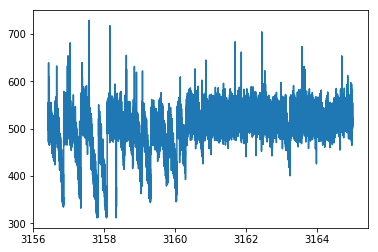

12434


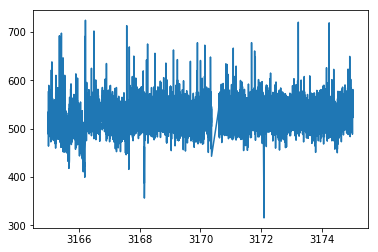

14120


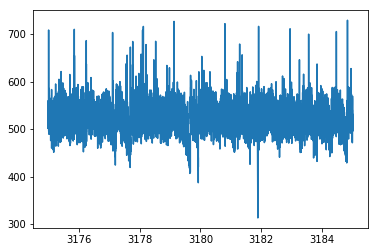

14512


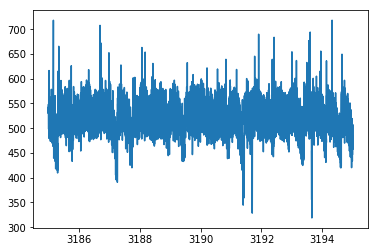

14542


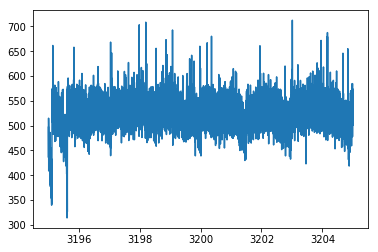

14532


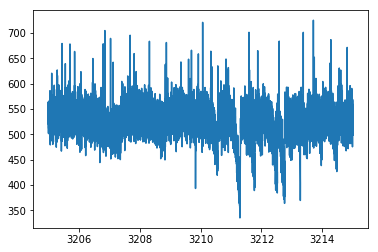

14507


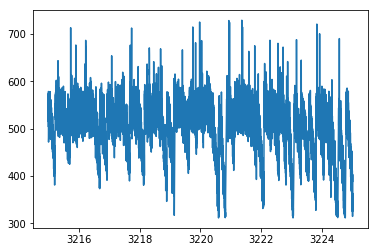

14297


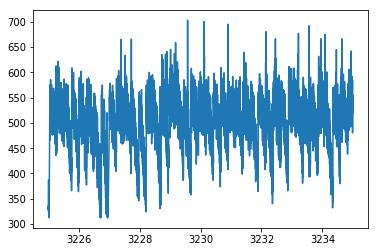

14347


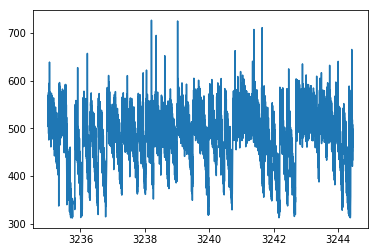

13486


In [22]:
plt.plot(first10time,first10flux)
plt.show()
print(len(first10time))

plt.plot(second10time,second10flux)
plt.show()
print(len(second10time))

plt.plot(third10time,third10flux)
plt.show()
print(len(third10time))

plt.plot(fourth10time,fourth10flux)
plt.show()
print(len(fourth10time))

plt.plot(fifth10time,fifth10flux)
plt.show()
print(len(fifth10time))

plt.plot(sixth10time,sixth10flux)
plt.show()
print(len(sixth10time))

plt.plot(seventh10time,seventh10flux)
plt.show()
print(len(seventh10time))

plt.plot(eighth10time,eighth10flux)
plt.show()
print(len(eighth10time))

plt.plot(ninth10time,ninth10flux)
plt.show()
print(len(ninth10time))

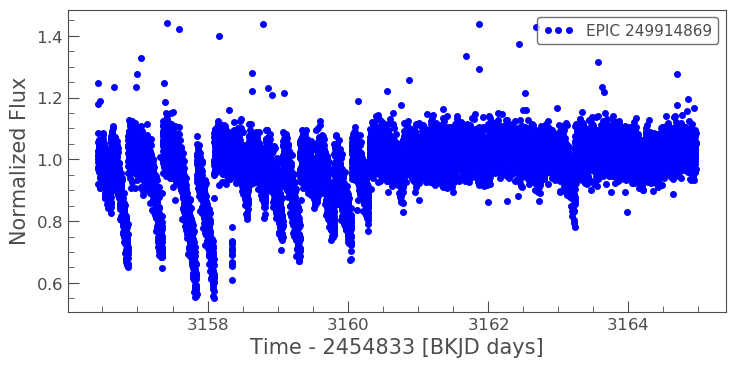

In [23]:
import matplotlib.pyplot as plt

user_lc_first = tpf[1:12434].to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool))
# Clean the light curve
user_lc_first = user_lc_first.remove_nans().remove_outliers()
user_lc_first.plot(marker='o',linestyle='None',markersize=4,color='blue')

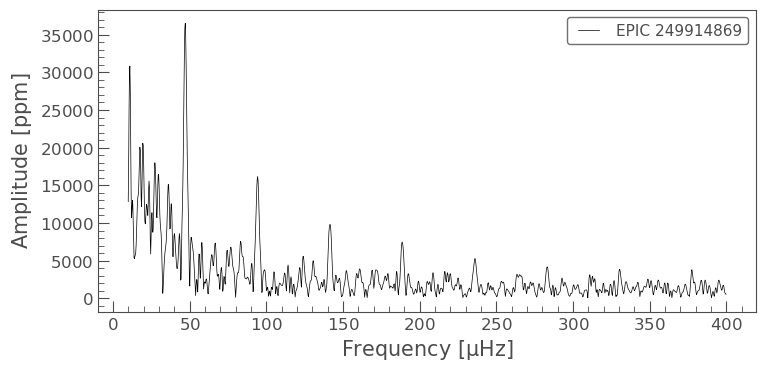

In [24]:
p = user_lc_first.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = p.plot(c='k');

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 10. d>

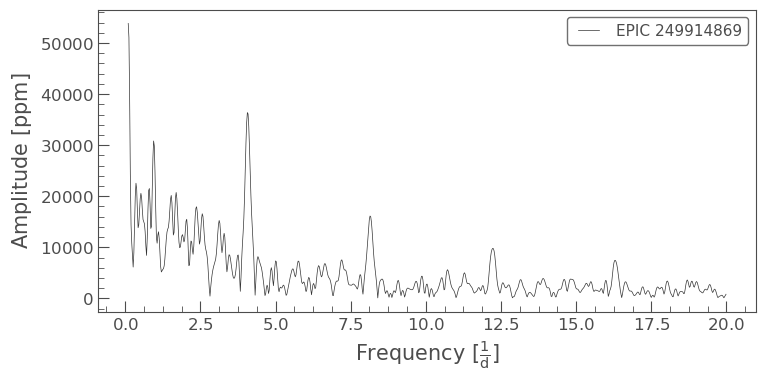

In [25]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc_first, minimum_period=0.05, maximum_period =10)
periodogram.plot()
periodogram.period_at_max_power

In [26]:
lc_first = tpf[1:12434].to_lightcurve().normalize().remove_nans().remove_outliers()
clc_first = lc_first.correct(windows=10).remove_outliers().fill_gaps()
#clc_first.plot()

/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)


<Quantity 0.11543646 d>

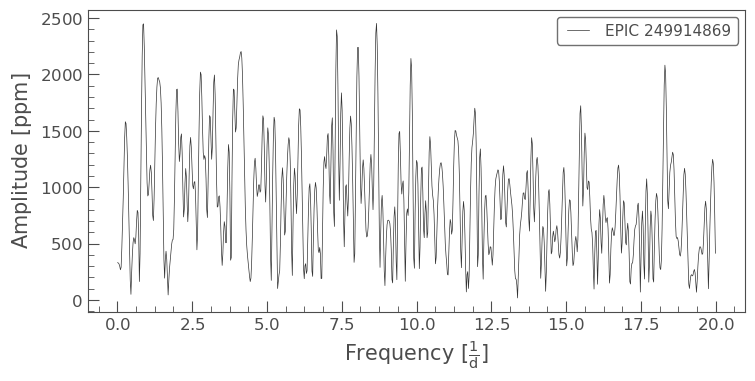

In [74]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc_first, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

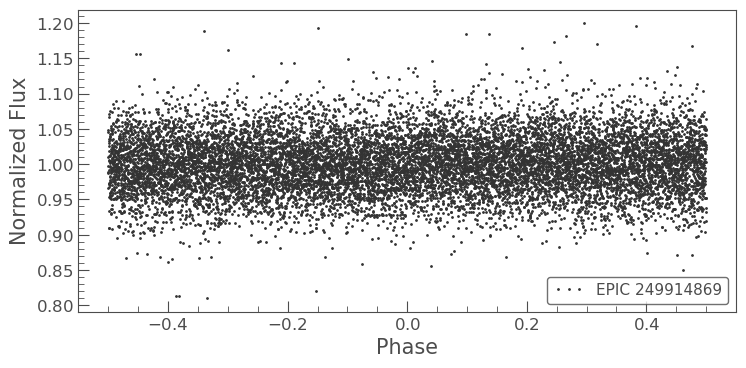

In [75]:
folded_lightcurve = clc_first.fold(periodogram.period_at_max_power.value)
folded_lightcurve.plot(marker='o',linestyle='none')

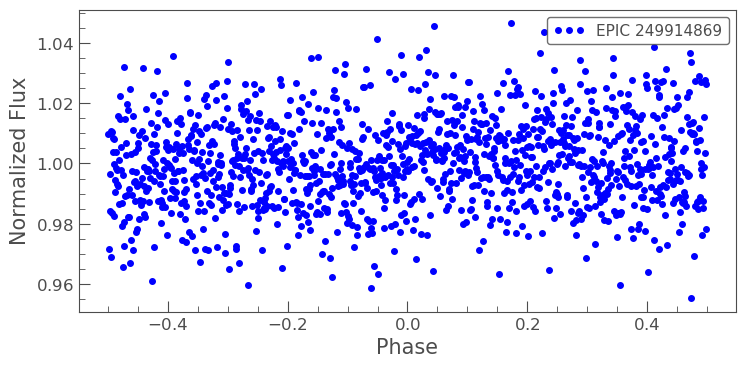

In [76]:
bin_folded_lc_first = folded_lightcurve.bin(10,method='median')
bin_folded_lc_first.plot(marker='o',linestyle='None',markersize=4,color='blue')

In [77]:
corrector=lk.SFFCorrector(lc_first)
new_lc_first = corrector.correct(lc_first.centroid_col,lc_first.centroid_row)

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 1.13944222 d>

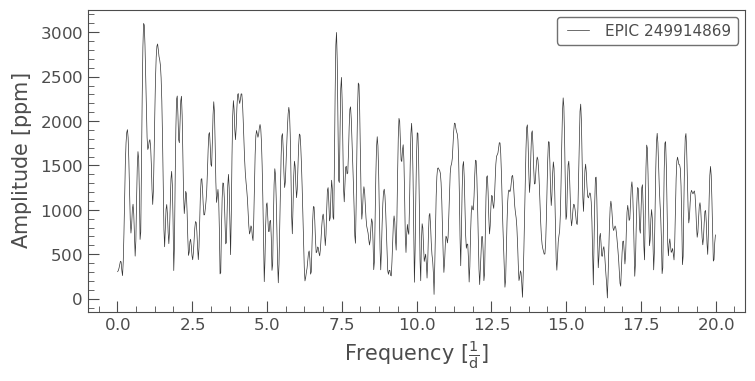

In [78]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(new_lc_first, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

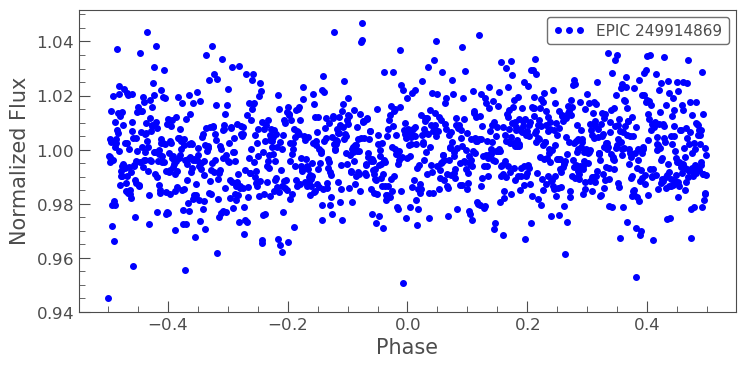

In [103]:
folded_lightcurve = new_lc_first.fold(periodogram.period_at_max_power.value)
bin_folded_lc_first = folded_lightcurve.bin(10,method='median')
bin_folded_lc_first.plot(marker='o',linestyle='None',markersize=4,color='blue')

-0.0021470396761173773


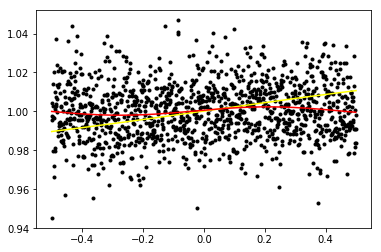

In [104]:
N = len(bin_folded_lc_first.flux) # number of data points
t = np.linspace(-0.5, 0.5, N)
guess_mean = np.mean(bin_folded_lc_first.flux)
guess_std = 3*np.std(bin_folded_lc_first.flux)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_first.flux
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
fine_t = np.arange(-0.5,0.5,0.001)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
plt.plot(t, bin_folded_lc_first.flux, marker='.', linestyle='none', color='black')
plt.plot(t, data_first_guess, label='first guess', color='yellow')
plt.plot(fine_t, data_fit, label='after fitting', color='red')
print(est_amp)

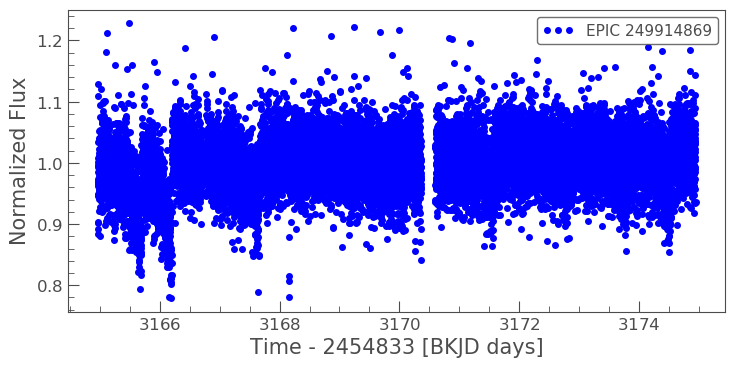

In [105]:
user_lc_second = tpf[12435:26555].to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool))
# Clean the light curve
user_lc_second = user_lc_second.remove_nans().remove_outliers()
user_lc_second.plot(marker='o',linestyle='None',markersize=4,color='blue')

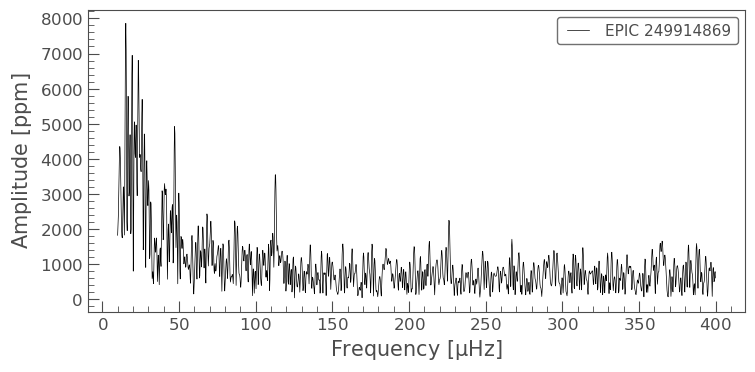

In [106]:
p = user_lc_second.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = p.plot(c='k');

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 10. d>

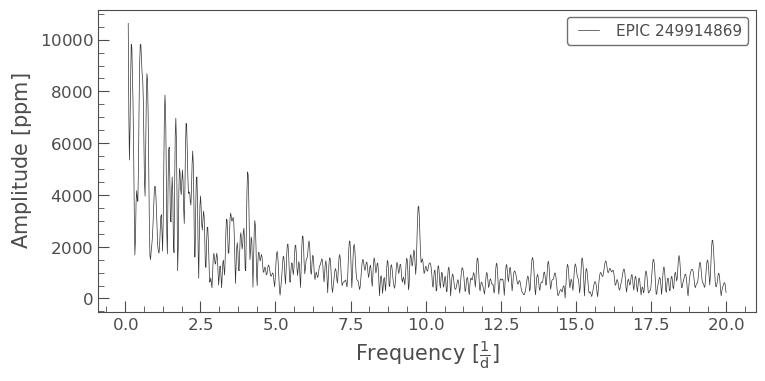

In [107]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc_second, minimum_period=0.05, maximum_period =10)
periodogram.plot()
periodogram.period_at_max_power

In [108]:
lc_second = tpf[12435:26555].to_lightcurve().normalize().remove_nans().remove_outliers()
clc_second = lc_second.correct(windows=10).remove_outliers().fill_gaps()

/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)


/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 1.8136981 d>

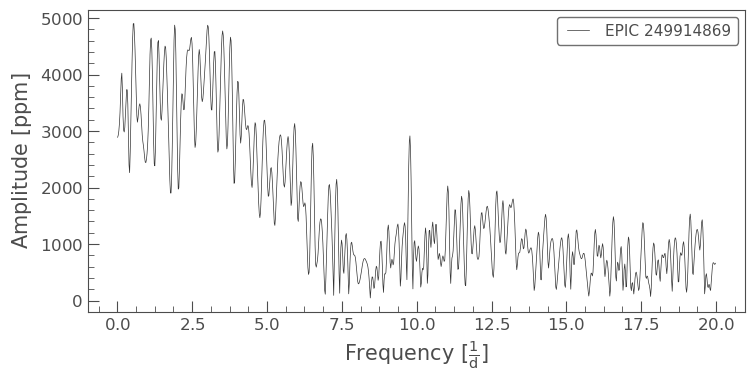

In [109]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc_second, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

In [115]:
folded_lightcurve_second = clc_second.fold(periodogram.period_at_max_power.value)
bin_folded_lc_second = folded_lightcurve_second.bin(10,method='median')

In [116]:
corrector=lk.SFFCorrector(lc_second)
new_lc_second = corrector.correct(lc_second.centroid_col,lc_second.centroid_row)

0.10230676659965314

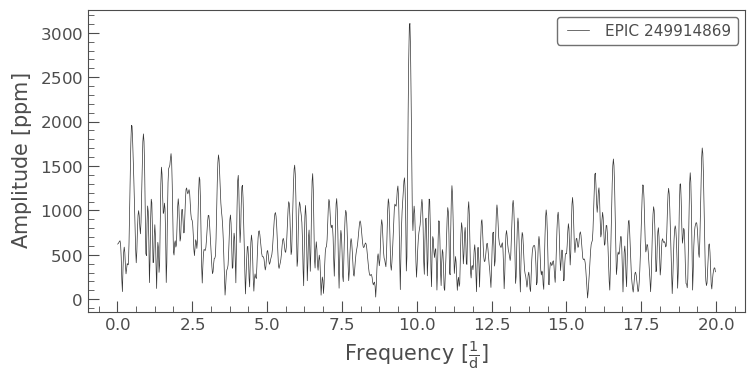

In [134]:
periodogram_second=lk.periodogram.LombScarglePeriodogram.from_lightcurve(new_lc_second, minimum_period=0.05, maximum_period =100)
periodogram_second.plot()
periodogram_second.period_at_max_power.value

In [ ]:
0.10252948369492497

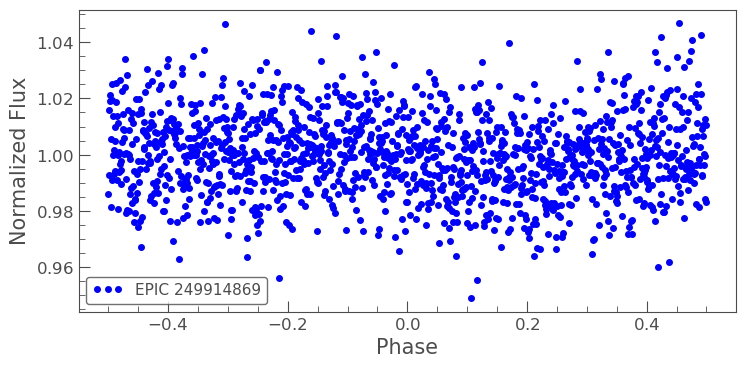

In [135]:
folded_lightcurve_second = new_lc_second.fold(periodogram_second.period_at_max_power.value)
bin_folded_lc_second = folded_lightcurve_second.bin(10,method='median')
bin_folded_lc_second.plot(marker='o',linestyle='None',markersize=4,color='blue')

-0.003505896736185467


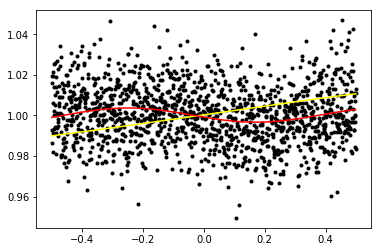

In [136]:
N = len(bin_folded_lc_second.flux) # number of data points
t = np.linspace(-0.5, 0.5, N)
guess_mean = np.mean(bin_folded_lc_second.flux)
guess_std = 3*np.std(bin_folded_lc_second.flux)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_second.flux
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
fine_t = np.arange(-0.5,0.5,0.001)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
plt.plot(t, bin_folded_lc_second.flux, marker='.', linestyle='none', color='black')
plt.plot(t, data_first_guess, label='first guess', color='yellow')
plt.plot(fine_t, data_fit, label='after fitting', color='red')
print(est_amp)

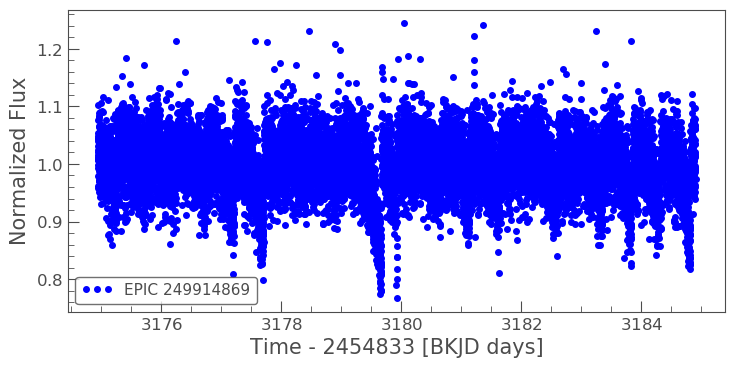

In [30]:
user_lc_third = tpf[26556:41068].to_lightcurve(aperture_mask=tpf.pipeline_mask.astype(bool))
# Clean the light curve
user_lc_third = user_lc_third.remove_nans().remove_outliers()
user_lc_third.plot(marker='o',linestyle='None',markersize=4,color='blue')

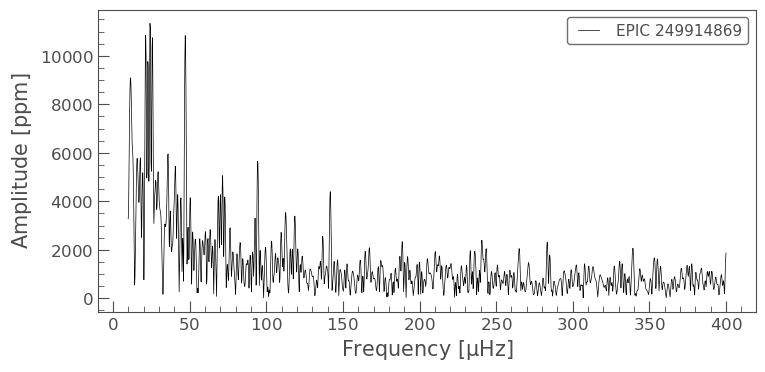

In [31]:
p = user_lc_third.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = p.plot(c='k');

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.47899266 d>

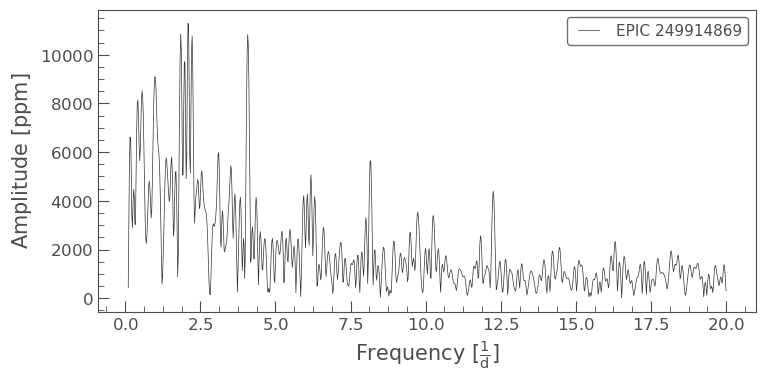

In [32]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc_third, minimum_period=0.05, maximum_period =10)
periodogram.plot()
periodogram.period_at_max_power

/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:1436: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)


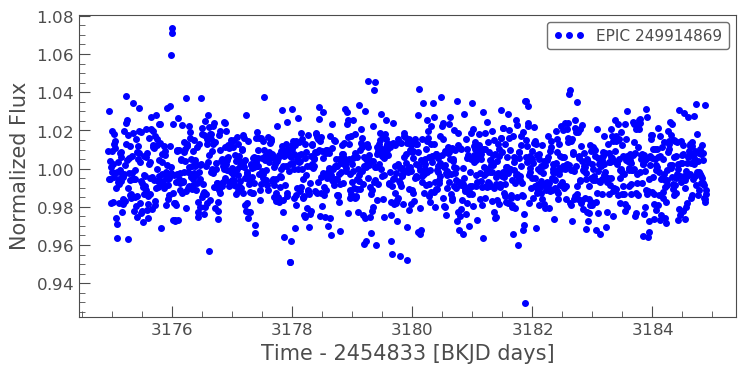

In [48]:
lc_third = tpf[26556:41068].to_lightcurve().normalize().remove_nans().remove_outliers()
clc_third = lc_third.correct(windows=10).remove_outliers().fill_gaps()
clc_binned_third = clc_third.bin(10,method='median')
clc_binned_third.plot(marker='o',linestyle='None',markersize=4,color='blue')

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.10279905 d>

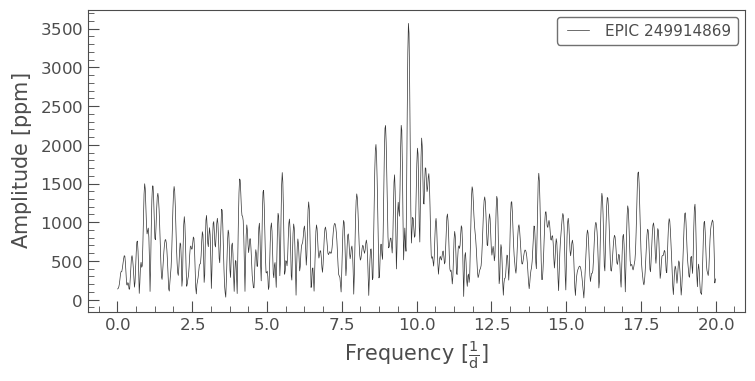

In [34]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc_third, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

In [38]:
folded_lightcurve_third = clc_third.fold(periodogram.period_at_max_power.value)
bin_folded_lc_third = folded_lightcurve_third.bin(10,method='median')

In [40]:
corrector=lk.SFFCorrector(lc_third)
new_lc_third = corrector.correct(lc_third.centroid_col,lc_third.centroid_row)

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.10279905 d>

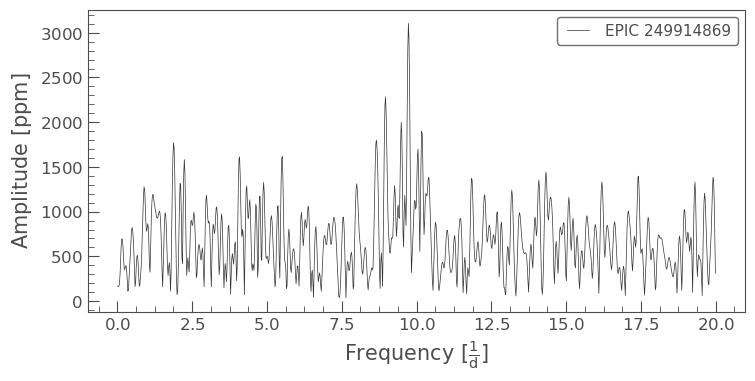

In [41]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(new_lc_third, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

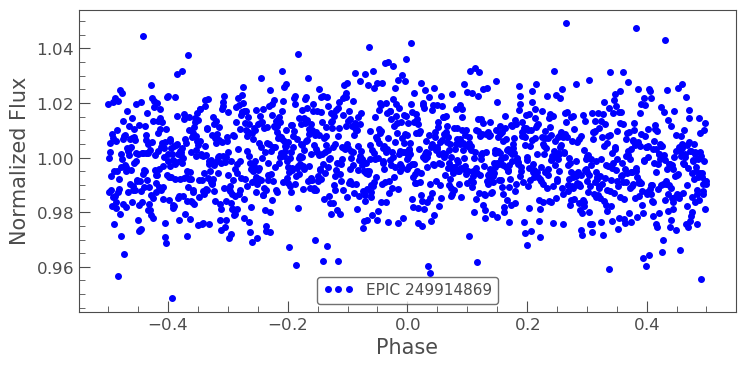

In [42]:
folded_lightcurve_third = new_lc_third.fold(periodogram.period_at_max_power.value)
bin_folded_lc_third = folded_lightcurve_third.bin(10,method='median')
bin_folded_lc_third.plot(marker='o',linestyle='None',markersize=4,color='blue')

0.0035553192971787564


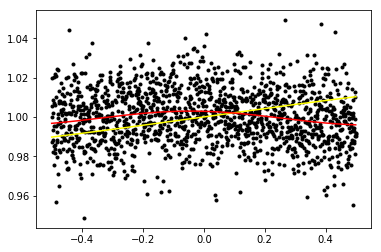

In [43]:
N = len(bin_folded_lc_third.flux) # number of data points
t = np.linspace(-0.5, 0.5, N)
guess_mean = np.mean(bin_folded_lc_third.flux)
guess_std = 3*np.std(bin_folded_lc_third.flux)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc_third.flux
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
fine_t = np.arange(-0.5,0.5,0.001)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
plt.plot(t, bin_folded_lc_third.flux, marker='.', linestyle='none', color='black')
plt.plot(t, data_first_guess, label='first guess', color='yellow')
plt.plot(fine_t, data_fit, label='after fitting', color='red')
print(est_amp)